In [1]:
! pip install pandas
! pip install sklearn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Tanu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [2]:
! pip install fuzzywuzzy
! pip install requests


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Tanu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Tanu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# inputs Ramaiah- lat-13.030554253361414 long-77.56535561927038
# Dominoes pizza- lat-12.9451436 long -77.5680133
import requests
import json
import os

HERE_API_KEY = "x5KUwxR61NhJS9DU-sCQupq-p4GxKqgcMK6YLJzwR2g"
DATA_FILE = "merchant_data.json"

# Load merchant memory from file if it exists
if os.path.exists(DATA_FILE):
    with open(DATA_FILE, "r") as f:
        merchant_memory = json.load(f)
else:
    merchant_memory = {}

def save_merchant_memory():
    with open(DATA_FILE, "w") as f:
        json.dump(merchant_memory, f, indent=4)

def get_shop_category_from_coordinates(lat, lng):
    base_url = "https://browse.search.hereapi.com/v1/browse"
    params = {
        "at": f"{lat},{lng}",
        "limit": 1,
        "apiKey": HERE_API_KEY
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()

        items = data.get("items", [])
        if not items:
            print("❌ No shops found near this location.")
            return None

        shop = items[0]
        title = shop.get("title")
        category = shop.get("categories", [{}])[0].get("name", "Unknown")
        address = shop.get("address", {}).get("label", "Unknown")
        position = shop.get("position")

        # Create unique key for memory
        key = f"{title}_{address}"

        if key in merchant_memory:
            saved_category = merchant_memory[key]['category']
            print(f"✅ Category: {saved_category}")
            return saved_category
        else:
            merchant_info = {
                "title": title,
                "category": category,
                "address": address,
                "position": position
            }
            merchant_memory[key] = merchant_info
            save_merchant_memory()
            print(f"💾 Saved and categorized as: {category}")
            return category

    except requests.exceptions.RequestException as e:
        print("⚠️ Error:", e)
        return None

# Run once
if __name__ == "__main__":
    try:
        lat = float(input("Enter latitude: "))
        lng = float(input("Enter longitude: "))
        get_shop_category_from_coordinates(lat, lng)
    except ValueError:
        print("⚠️ Please enter valid coordinates.")


🎯 Recommended Categories based on your input:
Food & Drink        12.146401
Shopping             9.448104
Health & Fitness     6.858368
Entertainment        0.000000
Travel              -1.826939
dtype: float64


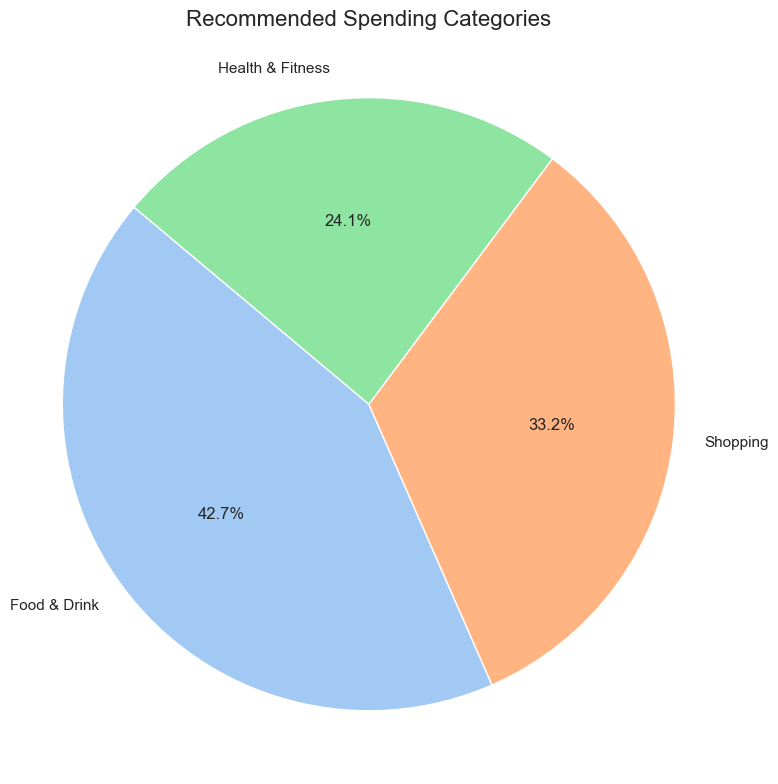

C:\Users\Tanu\AppData\Local\Temp\ipykernel_11956\3577119610.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=filtered_scores.values, y=filtered_scores.index, palette="crest")


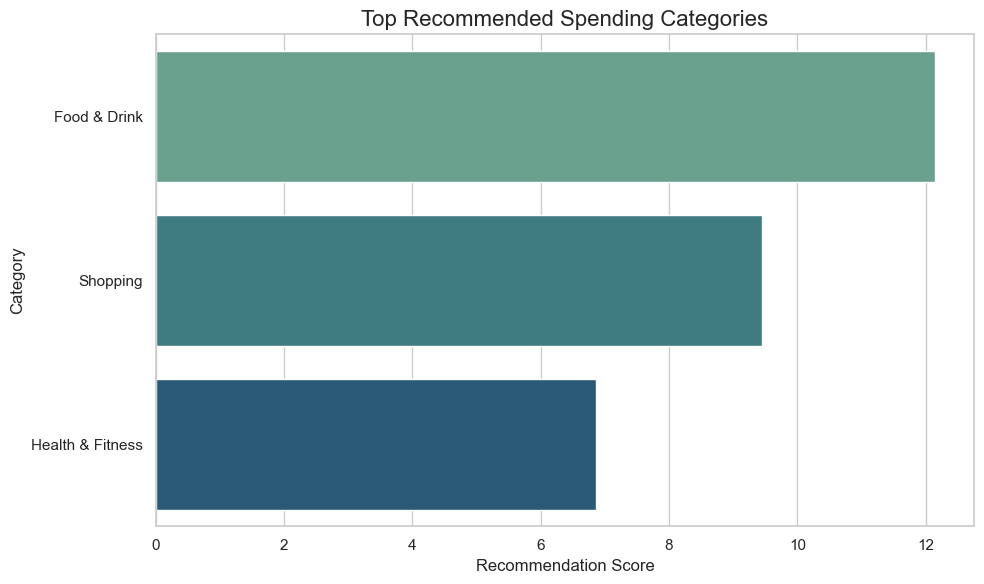

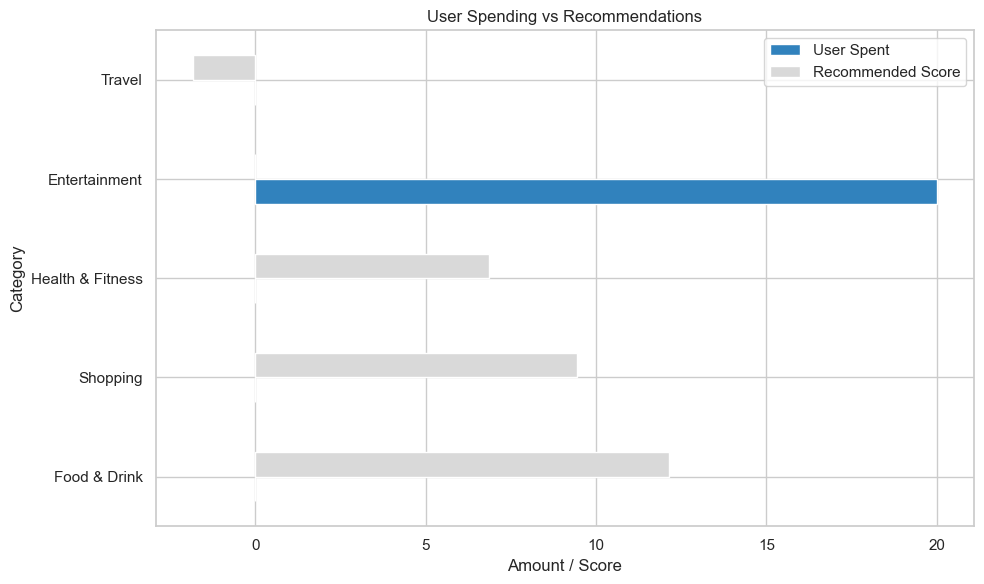

In [13]:

import json
from collections import defaultdict
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process

# ---------- Predefined Categories ----------
predefined_categories_map = {
    "Entertainment": [
        "movie", "cinema", "netflix", "concert", "fun", "game", "spotify", "hotstar"
    ],
    "Food & Dining": [
        "food", "restaurant", "drinks", "cafe", "pizza", "coffee", "dominos", "starbucks", "dining"
    ],
    "Healthcare": [
        "gym", "fitness", "health", "workout", "yoga", "medicine", "clinic", "1mg", "visit"
    ],
    "Rent & Housing": [
        "rent", "hostel", "lease", "apartment", "pg", "room"
    ],
    "Income": [
        "salary", "income", "pay", "payment", "credited", "freelance", "payout"
    ],
    "Shopping": [
        "shopping", "amazon", "flipkart", "mall", "clothes", "grocery", "store"
    ],
    "Travel": [
        "travel", "uber", "ola", "bus", "train", "flight", "trip", "irctc", "indigo", "makemytrip"
    ],
    "Utilities": [
        "electricity", "internet", "wifi", "recharge", "bill", "water", "airtel", "vodafone"
    ],
    "Others": [
        "bank", "credit", "card", "misc", "other", "subscription", "unknown"
    ]
}



flat_keywords = {}
for main_cat, keywords in predefined_categories_map.items():
    for keyword in keywords:
        flat_keywords[keyword.lower()] = main_cat

all_main_categories = list(predefined_categories_map.keys())

# ---------- Preprocessing Function ----------
def preprocess_category(raw_category):
    cat = raw_category.lower().strip()

    # Direct match
    if cat in all_main_categories:
        return cat

    # Check keywords
    for keyword, main_cat in flat_keywords.items():
        if keyword in cat:
            return main_cat

    # Fuzzy match as fallback
    match, score = process.extractOne(cat, all_main_categories)
    return match

# ---------- Collect User Spending Data ----------
with open("merchant_data.json", "r") as file:
    user_data = json.load(file)

user_spending = {}

for key, entry in user_data.items():
    original_category = entry.get("category", "").strip()

    if original_category:
        # Preprocess category to normalize it
        category = preprocess_category(original_category)

        if category not in user_spending:
            try:
                amount = input(f"Enter amount spent in '{category}' (original: '{original_category}') (Leave empty for no amount): ")
                amount = float(amount) if amount else None
            except ValueError:
                amount = None

            user_spending[category] = amount
        else:
            print(f"Amount already entered for '{category}', skipping input.")

# ---------- Recommendation Engine ----------
processed_dataset = pd.read_csv("processed_user_category_matrix.csv", index_col=0)

item_similarity = pd.DataFrame(
    cosine_similarity(processed_dataset.T),
    index=processed_dataset.columns,
    columns=processed_dataset.columns
)



# Only keep categories that exist in the dataset
valid_categories = [cat for cat in user_spending if cat in item_similarity.columns]

# Create user vector (all 0s initially)
user_vector = pd.Series(0, index=item_similarity.columns, dtype=float)

for cat in valid_categories:
    amount = user_spending[cat]
    if amount is None:
        continue  # Leave as 0 for collaborative filtering
    user_vector[cat] = amount if amount > 0 else 1  # Your original logic preserved

# Calculate scores
scores = item_similarity.dot(user_vector)

# Remove already present categories from scoring
scores.loc[valid_categories] = 0  # Make sure to use .loc with list, not dict_keys

# Recommend top 5 categories
top_recommendations = scores.sort_values(ascending=False).head(5)

print("\n🎯 Recommended Categories based on your input:")
for category, amount in user_spending.items():
    if amount is None:
        print(f"\nNo amount entered for '{category}', using collaborative filtering instead.")

print(top_recommendations)

import seaborn as sns
import matplotlib.pyplot as plt

# Apply seaborn styling
sns.set_theme(style="whitegrid")

# Filter out zero or NaN values
filtered_scores = top_recommendations[top_recommendations > 0]

# Plot pie chart using matplotlib, styled with seaborn theme
if not filtered_scores.empty:
    plt.figure(figsize=(8, 8))
    colors = sns.color_palette("pastel")[0:len(filtered_scores)]
    plt.pie(filtered_scores, labels=filtered_scores.index, autopct="%1.1f%%", startangle=140, colors=colors)
    plt.title("Recommended Spending Categories", fontsize=16)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
else:
    print("\nNothing to show in the pie chart (all recommendations have zero or missing values).")

import seaborn as sns
import matplotlib.pyplot as plt

# Filter non-zero recommendations
filtered_scores = top_recommendations[top_recommendations > 0]

plt.figure(figsize=(10, 6))
sns.barplot(x=filtered_scores.values, y=filtered_scores.index, palette="crest")
plt.title("Top Recommended Spending Categories", fontsize=16)
plt.xlabel("Recommendation Score")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


df_compare = pd.DataFrame({
    "User Spent": [user_spending.get(cat, 0) or 0 for cat in top_recommendations.index],
    "Recommended Score": top_recommendations.values
}, index=top_recommendations.index)

df_compare.plot(kind="barh", stacked=False, figsize=(10, 6), colormap="tab20c")
plt.title("User Spending vs Recommendations")
plt.xlabel("Amount / Score")
plt.ylabel("Category")
plt.tight_layout()
plt.show()




In [5]:
import requests
import json
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process
from collections import defaultdict

# API and file configuration
HERE_API_KEY = "x5KUwxR61NhJS9DU-sCQupq-p4GxKqgcMK6YLJzwR2g"
DATA_FILE = "merchant_data.json"
PROCESSED_DATA_FILE = "processed_user_category_matrix2.csv"

# ---------- Predefined Categories ----------
predefined_categories_map = {
    "Travel": ["travel", "uber", "ola", "bus", "train", "flight", "trip", "cab", "ticket", "airbnb"],
    "Income": ["salary", "income", "pay", "payment", "credited", "deposit", "refund"],
    "Utilities": ["electricity", "internet", "wifi", "recharge", "bill", "water", "gas", "phone", "utility"],
    "Food & Dining": ["food", "restaurant", "drinks", "cafe", "pizza", "coffee", "dining", "snack", "meal"],
    "Others": ["misc", "other", "general", "random", "etc"],
    "Subscriptions": ["netflix", "prime", "spotify", "subscription", "disney", "hotstar", "zee", "apple", "membership"],
    "Healthcare": ["medicine", "hospital", "clinic", "doctor", "health", "fitness", "medical", "pharmacy"],
    "Fuel": ["fuel", "petrol", "diesel", "gas", "refuel", "pump", "station"],
    "Shopping": ["shopping", "amazon", "flipkart", "mall", "clothes", "grocery", "store", "purchase", "retail"],
    "Entertainment": ["movie", "cinema", "concert", "fun", "game", "event", "show", "outing"]
}


flat_keywords = {}
for main_cat, keywords in predefined_categories_map.items():
    for keyword in keywords:
        flat_keywords[keyword.lower()] = main_cat

all_main_categories = list(predefined_categories_map.keys())

# ---------- Preprocessing Function ----------
def preprocess_category(raw_category):
    cat = raw_category.lower().strip()

    # Direct match
    if cat in all_main_categories:
        return cat

    # Check keywords
    for keyword, main_cat in flat_keywords.items():
        if keyword in cat:
            return main_cat

    # Fuzzy match as fallback
    match, score = process.extractOne(cat, all_main_categories)
    return match

# Load merchant memory from file if it exists
def load_merchant_memory():
    if os.path.exists(DATA_FILE):
        with open(DATA_FILE, "r") as f:
            return json.load(f)
    else:
        return {}

# Save merchant data to file
def save_merchant_memory(merchant_memory):
    with open(DATA_FILE, "w") as f:
        json.dump(merchant_memory, f, indent=4)

def get_shop_category_from_coordinates(lat, lng):
    # Load current merchant data
    merchant_memory = load_merchant_memory()
    
    base_url = "https://browse.search.hereapi.com/v1/browse"
    params = {
        "at": f"{lat},{lng}",
        "limit": 1,
        "apiKey": HERE_API_KEY
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()

        items = data.get("items", [])
        if not items:
            print("❌ No shops found near this location.")
            return None

        shop = items[0]
        title = shop.get("title")
        category = shop.get("categories", [{}])[0].get("name", "Unknown")
        address = shop.get("address", {}).get("label", "Unknown")
        position = shop.get("position")

        # Create unique key for memory
        key = f"{title}_{address}"

        if key in merchant_memory:
            saved_category = merchant_memory[key]['category']
            print(f"✅ Found in memory: {title} - Category: {saved_category}")
            return saved_category
        else:
            merchant_info = {
                "title": title,
                "category": category,
                "address": address,
                "position": position
            }
            merchant_memory[key] = merchant_info
            save_merchant_memory(merchant_memory)
            print(f"💾 Saved new merchant: {title} - Categorized as: {category}")
            
            # Trigger recommendation engine after updating the JSON
            generate_recommendations()
            
            return category

    except requests.exceptions.RequestException as e:
        print("⚠️ Error:", e)
        return None

def generate_recommendations():
    print("\n🔄 Generating recommendations based on updated merchant data...\n")
    
    # ---------- Collect User Spending Data ----------
    user_data = load_merchant_memory()
    
    if not user_data:
        print("⚠️ No merchant data available for recommendations.")
        return
    
    user_spending = {}

    for key, entry in user_data.items():
        original_category = entry.get("category", "").strip()

        if original_category:
            # Preprocess category to normalize it
            category = preprocess_category(original_category)

            if category not in user_spending:
                try:
                    merchant_name = entry.get("title", "Unknown Merchant")
                    prompt = f"Enter amount spent at '{merchant_name}' (category: '{category}') (Leave empty for no amount): "
                    amount = input(prompt)
                    amount = float(amount) if amount else None
                except ValueError:
                    print("⚠️ Invalid amount, skipping.")
                    amount = None

                user_spending[category] = amount
            else:
                print(f"Amount already entered for '{category}', skipping input.")

    # Check if we have enough data to make recommendations
    if not user_spending or all(amount is None for amount in user_spending.values()):
        print("⚠️ No spending amounts provided, cannot generate recommendations.")
        return
        
    # ---------- Recommendation Engine ----------
    try:
        # Check if processed dataset exists
        if os.path.exists(PROCESSED_DATA_FILE):
            processed_dataset = pd.read_csv(PROCESSED_DATA_FILE, index_col=0)
            
            item_similarity = pd.DataFrame(
                cosine_similarity(processed_dataset.T),
                index=processed_dataset.columns,
                columns=processed_dataset.columns
            )

            # Only keep categories that exist in the dataset
            valid_categories = [cat for cat in user_spending if cat in item_similarity.columns]

            if not valid_categories:
                print("⚠️ None of your categories match the recommendation database.")
                return

            # Create user vector (all 0s initially)
            user_vector = pd.Series(0, index=item_similarity.columns, dtype=float)

            for cat in valid_categories:
                amount = user_spending[cat]
                if amount is None:
                    continue  # Leave as 0 for collaborative filtering
                user_vector[cat] = amount if amount > 0 else 1

            # Calculate scores
            scores = item_similarity.dot(user_vector)

            # Remove already present categories from scoring
            scores.loc[valid_categories] = 0

            # Recommend top 5 categories
            top_recommendations = scores.sort_values(ascending=False).head(5)

            print("\n🎯 Recommended Categories based on your spending:")
            for category, amount in user_spending.items():
                if amount is None:
                    print(f"· No amount entered for '{category}', using collaborative filtering instead.")
                else:
                    print(f"· You spent ${amount:.2f} on {category}")
                    
            print("\n📊 Top Recommendations:")
            for category, score in top_recommendations.items():
                print(f"· {category} (score: {score:.2f})")
        else:
            print(f"⚠️ Recommendation data file '{PROCESSED_DATA_FILE}' not found.")
            print("Please ensure you have the processed user category matrix available.")
    except Exception as e:
        print(f"⚠️ Error generating recommendations: {str(e)}")

# Main execution
if __name__ == "__main__":
    while True:
        print("\n====== Merchant Category & Recommendation System ======")
        print("1. Enter coordinates to find a shop")
        print("2. Generate recommendations from existing data")
        print("3. Exit")
        choice = input("Select an option (1-3): ")
        
        if choice == "1":
            try:
                lat = float(input("Enter latitude: "))
                lng = float(input("Enter longitude: "))
                get_shop_category_from_coordinates(lat, lng)
            except ValueError:
                print("⚠️ Please enter valid coordinates.")
        elif choice == "2":
            generate_recommendations()
        elif choice == "3":
            print("Exiting. Thank you!")
            break
        else:
            print("Invalid choice. Please try again.")


====== Merchant Category & Recommendation System ======
1. Enter coordinates to find a shop
2. Generate recommendations from existing data
3. Exit



🔄 Generating recommendations based on updated merchant data...


🎯 Recommended Categories based on your spending:
· You spent $400.00 on Entertainment
· You spent $400.00 on Food & Dining

📊 Top Recommendations:
· Shopping (score: 215.51)
· Entertainment (score: 0.00)
· Food & Dining (score: 0.00)
· Travel (score: -2.11)
· Healthcare (score: -14.89)

====== Merchant Category & Recommendation System ======
1. Enter coordinates to find a shop
2. Generate recommendations from existing data
3. Exit
Exiting. Thank you!
